# 用一个全连接网络来分类minst库

In [7]:
# -*- coding:utf-8 -*-
import os
import time
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<img src="../image/dnn.png" alt="Drawing" style="width: 400px;" align="center"/>

下面利用pytorch的基本函数搭建一个DNN网络

In [8]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer, dropout, output_size):
        super(DNN, self).__init__()

        self.hidden_layer = hidden_layer

        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.ReLU(),
            )

        self.fc2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            )

        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=-1)
            )

    def forward(self, x):
        x = x.view(x.size(0),-1)
        out = self.fc1(x)
        for _ in range(self.hidden_layer):
            out = self.fc2(out)
        out = self.fc3(out)
        return out

创建数据集，这里需要需要下载好数据集，或者把download参数改成True，这样可以自动下载

In [4]:
def load_data(root, batch_size):
    image_size = 28
    data_tf = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), 
        transforms.ToTensor( ),
        transforms.Normalize(mean = (0.1307,), std = (0.3081,))
    ])

    train_data = datasets.MNIST(root=root,train=True,transform=data_tf,download=False)
    valid_data = datasets.MNIST(root=root,train=False,transform=data_tf,download=False)

    train_loader =torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
    valid_loader =torch.utils.data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=False)
    return train_loader, valid_loader, image_size*image_size

train函数

In [5]:

def train(train_loader, valid_loader, input_dim, learning_rate, epochs):
    model = DNN(input_dim, 128, 1, 0.0, 10).to(device)

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
    # create a loss function
    criterion = nn.NLLLoss()

    start_time = time.time()
    total_loss = []
    for epoch in range(epochs):
        model.train()
        
        train_loss, train_accs = [], []
        for _, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            result = model(data)
            loss = criterion(result, target)
            loss.backward()
            optimizer.step()

            accuarcy = (result.argmax(dim=-1).to('cpu') == target.to('cpu')).float().mean()  
            train_loss.append(loss.item())
            train_accs.append(accuarcy)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) /len(train_accs)
        print(f"[ Train | {epoch + 1:03d}/{epochs:03d} ] loss = {train_loss:.5f}, accuracy = {train_acc:.5f}")    
        
        # begin valid
        model.eval() 
        valid_loss, valid_accs = [], []
     
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            with torch.no_grad():
                result = model(data)

            loss = criterion(result, target)
            accuarcy = (result.argmax(dim=-1).to('cpu') == target.to('cpu')).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(accuarcy) 

        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        total_loss.append(valid_loss)
        print(f"[ Valid | {epoch + 1:03d}/{epochs:03d} ] loss = {valid_loss:.5f}, accuracy = {valid_acc:.5f}")

    time_span = time.time() - start_time
    print(f'Training is over, spending time {time_span/60:.1f} minutes \r\nvalid accuracy is {valid_acc:.5f}')
    return total_loss

数据集通常比较大，可以把数据集保存在一个固定的地方。这里通过环境变量来指定了保存的目录

[ Train | 001/004 ] loss = 0.39046, accuracy = 0.88792
[ Valid | 001/004 ] loss = 0.17719, accuracy = 0.94620
[ Train | 002/004 ] loss = 0.13948, accuracy = 0.95853
[ Valid | 002/004 ] loss = 0.10926, accuracy = 0.96680
[ Train | 003/004 ] loss = 0.09391, accuracy = 0.97197
[ Valid | 003/004 ] loss = 0.08562, accuracy = 0.97250
[ Train | 004/004 ] loss = 0.07012, accuracy = 0.97880
[ Valid | 004/004 ] loss = 0.08022, accuracy = 0.97440
Training is over, spending time 1.1 minutes 
valid accuracy is 0.97440


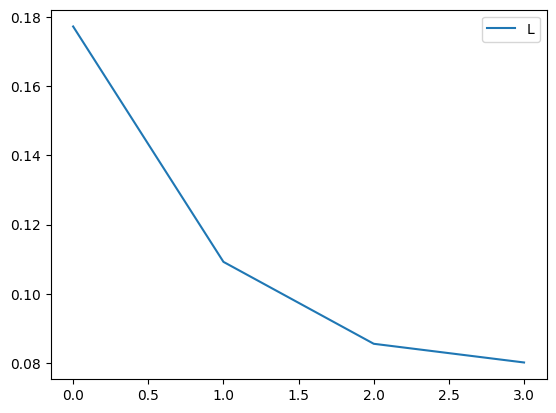

In [6]:
def main():
    data_root = Path(os.environ.get('ML_DATA_ROOT')).joinpath('mnist')
    train_loader, valid_loader, input_dim = load_data(data_root, batch_size = 100);
    losses = train(train_loader, valid_loader, input_dim, learning_rate = 0.01, epochs = 4)

    # 绘制损失函数曲线
    plt.figure('DNN')
    plt.plot(losses, label='Loss')
    plt.legend('Loss')
    plt.show()

if __name__ == "__main__":
    main()